# Two Spatial Information Score Implementations ?

I wanted to learn more about information score, as defined by Skaggs et al. in a 1996 paper in Hippocampus.

My sudden interest came about because I sometimes see that people report negative scores expressed as bits per spikes. Using my own implementation, all scores were >= 0. This was puzzling me.

I am not advocating for or against the use of this score, I just want to understand why people could get negative values but I could not.

When I try to implement the formula, as shown below, I first failed to get negative scores when simulations random data using random spike and occupancy numbers taken from poisson distributions.

My suspission is that there are two implementations of the formula out there and that a key difference is how the **mean firing rate** of the neuron is calculated. To the coder, there are 2 obvious possibilities:

* The mean firing rate is calculated by taking the average of all firing rate bins of the map
* The mean firing rate is calculated from the sum of all spikes divided by the sum of occupancy values.

We will test whether this could explain why some people obtain negative negative bits/spikes, whereas other don't.

I took the formula from Skaggs and colleagues (1996, Hippocampus).

\begin{equation*}
Info(x) = \sum_{n=1}^{N} p_i \frac{\lambda_i}{\lambda} log2 \frac{\lambda_i}{\lambda}
\end{equation*}


My python implementation is shown below. I added an argument to allow us to calculate the mean rate with the two methods mentioned above.

See also a interesting Twitter thread on the subject: https://twitter.com/KevinAllenLab/status/1316723591749173250)

In [1]:
import numpy as np

def spatialInformationScore(spikes,times,meanRateOcc=True):
    """
    spikes: array containing the number of spikes per spatial bin
    times: array with the time spent in each bin, in seconds
    meanRateOcc: boolean, if True will calculate the mean rate :  spikes.sum()/times.sum(), otherwise rate.mean()
    
    """
    # Check if there are bins with a time of 0, get rid of them
    # after all, there are many other bins in the world that were not visited and were not included
    spikes = spikes[times>0]
    times = times[times>0]
    
        
    # We need the firing rate per bin, defined as spikes/time
    rate = spikes/times
    
    # mean rate of the cell
    # I presume this should take into account the occupancy in each bin
    if meanRateOcc:
        mrate = spikes.sum()/times.sum()
    else:
        mrate = rate.mean()
    
    
    # probability to occupy a bin
    prob=times/times.sum()
     
    # one issue is that np.log2 of 0 is -inf.
    # when this occurs because rate is 0, then -inf is multiplied by 0.
    # so we can just get rid of these in the summation
    
    index = rate>0
    return sum(prob[index] * (rate[index]/mrate) * np.log2(rate[index]/mrate))
 

## Number of bins

Let's keep the occupancy fixed at 1 sec per bin and only one spike in one bin.

Imagine that the cell fires only in one of 2 bins, this should give us 1 bit per spike.
If we had 4 bins and the cell fires only in 1, then this is 2 bits per spike.

Let's have a look at how information score would change as a function of the number of bins.

This shows the influence of the number of bins in the map on the information score. Because of this effect, one should be very carefull when comparing scores across studies.

For 256 bins we get a spatial info score of 8.0.


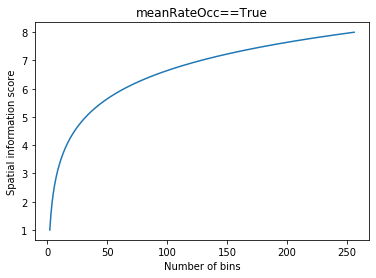

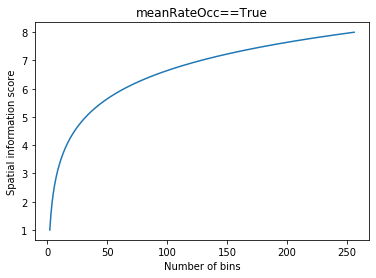

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
maxBins=256

Info = np.zeros((len(range(2,maxBins+1)),2))

for x in range(2,maxBins+1):
    spikes=np.zeros(x)
    times=np.ones(x)
    spikes[0]=1 # add a spike in one bin
    Info[x-2,0] = spatialInformationScore(spikes,times,meanRateOcc=False)
    Info[x-2,1] = spatialInformationScore(spikes,times,meanRateOcc=True)

print("For {} bins we get a spatial info score of {}.".format(maxBins, np.max(Info)))
plt.plot(np.arange(2,maxBins+1),Info[:,0])
plt.xlabel("Number of bins")
plt.ylabel("Spatial information score")
plt.title("meanRateOcc==True")
plt.show()


plt.plot(np.arange(2,maxBins+1),Info[:,1])
plt.xlabel("Number of bins")
plt.ylabel("Spatial information score")
plt.title("meanRateOcc==True")
plt.show()



This make intiutive sense, as you can represent 256 numbers with 8 bits. 

In this case, the two methods to get the mean firing rate give the same spatial information scores.

## Random occupancy and spike counts

Now we will create random spikes and times arrays by sampling different poisson distributions.

We will calculate the mean firing rate using the two possible ways (meanRateOcc argument).

We used a lambda of 5 and 10 in this example.

0.23442128262650835
0.02815782730928323


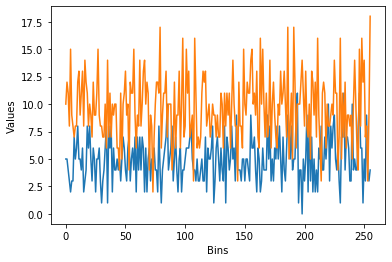

In [3]:
nBins=256
spikes = np.random.poisson(5,nBins)
times = np.random.poisson(10,nBins)
print(spatialInformationScore(spikes,times,meanRateOcc=True))
print(spatialInformationScore(spikes,times,meanRateOcc=False))

## plot the spikes and time arrays
plt.plot(spikes)
plt.plot(times)
plt.xlabel("Bins")
plt.ylabel("Values")
plt.show()

Here we get very different spatial information content. Let's try several times to get an idea of the distribution of scores we would get by chance (using 2 well selected poisson distributions to show my point).

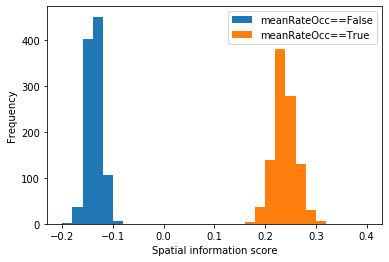

In [4]:
nIters=1000
Info = np.zeros((nIters,2)) # 2 for the True and False

for b in range(2):
    for x in range(nIters):
        spikes = np.random.poisson(14,nBins)
        times = np.random.poisson(4,nBins)
        Info[x,b] = spatialInformationScore(spikes,times,meanRateOcc=bool(b))

plt.hist(Info[:,0],bins=30,range=[-0.2,0.4], label='meanRateOcc==False')
plt.hist(Info[:,1],bins=30,range=[-0.2,0.4],label='meanRateOcc==True')
plt.xlabel("Spatial information score")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("SIS.png")

So we are getting very different distribution of spatial information scores depending on the way the mean firing rate is calculated.

Now let's explore how this changes depending on the distribution of the values in the spikes and times arrays. To do so we will manipulate the lambda of the poisson distribution.

In [ ]:
nBins=256 # number of bins in the map
nIters=100 # number of calls to the Info function
Info = np.zeros(nIters) # to store the Info scores
maxLambda=20 # for our poisson distribution
medianInfo = np.zeros(shape=(maxLambda,maxLambda,2)) # to store the median Info score per lambda conditions
for b in range(2):
    for s in range(1,maxLambda+1): # loop for spikes
        for t in range(1,maxLambda+1): # loop for times
            for x in range(nIters):
                spikes = np.random.poisson(s,nBins)
                times = np.random.poisson(t,nBins)
                Info[x] = spatialInformationScore(spikes,times,meanRateOcc=bool(b))
            medianInfo[t-1,s-1,b] = np.median(Info)


In [ ]:
plt.imshow(medianInfo[:,:,0],extent=[1,maxLambda,1,maxLambda],origin='lower')
plt.xlabel("Spike lambda")
plt.ylabel("Occupancy lambda")
plt.colorbar()
plt.title("meanRateOcc==False")
plt.show()

plt.hist(medianInfo[:,:,0].reshape((-1,1)),bins=30,range=[-0.2,0.8])
plt.title("meanRateOcc==False")
plt.show()

plt.imshow(medianInfo[:,:,1],extent=[1,maxLambda,1,maxLambda],origin='lower')
plt.xlabel("Spike lambda")
plt.ylabel("Occupancy lambda")
plt.colorbar()
plt.title("meanRateOcc==True")
plt.show()

plt.hist(medianInfo[:,:,1].reshape((-1,1)),bins=30,range=[-0.2,0.8])
plt.title("meanRateOcc==True")
plt.show()

## Conclusion

I suspect that there are two implementations of the spatial information scores out there in different labs. 

Depending on how the mean firing rate is calculated, one can observe negative values. 

People having worked extensively with this formula seem to agree that the results should always be > 0.
(https://twitter.com/neuralengine/status/1317536663325843457).
